# Predicting How Users Will Like Animes

Previously, we attempted to predict how users will rate an anime using linear regression. Our prelimenary results showed that it was difficult to create a linear model that can accurately predict how users will rate an anime. Thus, we decided to limit our scope to whenether or not a user will like an anime, and attempt to use the SVM classifier to predict this.

In [19]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import train_test_split
from scipy.stats.stats import pearsonr
from itertools import combinations_with_replacement
from sklearn.svm import LinearSVC
from collections import defaultdict
from sklearn.grid_search import GridSearchCV

### Categorizing Animes into Good or Bad

To do this, we first have to determine how to classify a "good" anime versus a "bad" anime. In our dataset, users have rated animes according to the film's animation, character, sound, story, and overall score. In order to leverage all this information, the average of these scores was taken to determine an overall average score for each anime.

Next, we need to decide on how to categorize good and bad. While we could decide on an arbitary cutoff value, it'll be hard to come up with an arbitary value that would make sense for our data set. For instance, while an average of 5/10 theoretically should an average film, the true average isn't at this value. Thus, we decided to categorize a good anime as having an at or above average score, while bad animes have below average scores. 

In [2]:
final = pd.read_csv('../data/final_review.csv',index_col=0)

In [3]:
final.loc[:,'average'] = np.nanmean(final.loc[:,['animation','character','overall','sound','story']],axis=1)

In [4]:
#deleting unessential columns
df = final.drop(['animation','character','overall','sound','story','anime_name','reviews'],1)

#converting sex to indicator
sex = []

for row in df.index:
    if df.ix[row,'sex']=='M':
        sex.append(1)
    elif df.ix[row,'sex']=='F':
        sex.append(0)
    else:
        sex.append(-1)
        
df.loc[:,'sex'] = sex

In [5]:
mean = df.loc[:,'average'].mean()
mean

7.23730245046724

In [6]:
response = []

for row in df.index:
    if df.ix[row,'average']>=mean:
        response.append(1)
    else:
        response.append(0)
        
df.loc[:,'average'] = response

In [7]:
df.loc[:,'average'].mean()

0.5694428288938002

### Standardize

Now that we have our data matrix set up, we want to explore the relationship of these independent variables with the response variable. In this case, the only non-indicator variable is age, so a KDE plot was set up to look for a separation of response variables. After standardizing the age variable (separately for train and test), and plotting the KDE, it seems that there is a slight separation in age between good and bad animes.

In [8]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)

In [9]:
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [10]:
from sklearn.preprocessing import StandardScaler

valstrain=df['age'].values[mask]
valstest=df['age'].values[~mask]
scaler=StandardScaler().fit(valstrain)
outtrain=scaler.transform(valstrain)
outtest=scaler.fit_transform(valstest)
out=np.empty(mask.shape[0])
out[mask]=outtrain
out[~mask]=outtest
df['age']=out

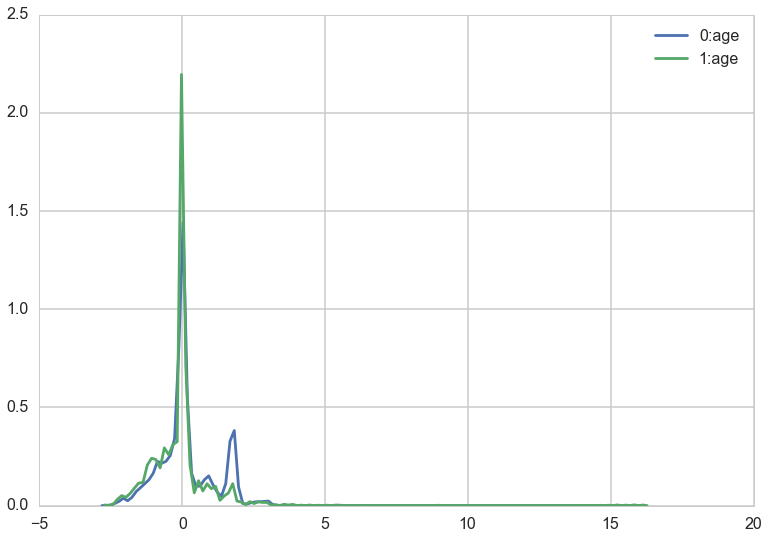

In [11]:
#testing predictors
dfgb=df.groupby('average')
for k, v in dfgb['age']:
        sns.kdeplot(v, label=str(k)+":"+v.name)

### Baseline

To be able to compare our classifiers, we first need a baseline. Here, we create two baselines, one that assumes all users dislikes all animes, and another that assumes that all users love all animes. Here, we find that with the training data, the baseline for everyone liking is 56%, and everyone disliking is 43%.

In [45]:
#columns to grab
lcols = df.columns[2:134].tolist()
Xmatrix=df[lcols].values
Yresp=df['average'].values

#creating test and train dataframes
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [54]:
#all users like animes
basex_like = np.ones(len(Xmatrix_train))

#all users hate animes
basex_dislike = np.zeros(len(Xmatrix_train))

accuracy_like = [i[0] == i[1] for i in zip(basex_like,Yresp_train)]
accuracy_dislike = [i[0] == i[1] for i in zip(basex_dislike,Yresp_train)]

In [61]:
accuracy_like_score = sum(accuracy_like)/float(len(accuracy_like))
accuracy_dislike_score = sum(accuracy_dislike)/float(len(accuracy_dislike))

In [62]:
accuracy_like_score, accuracy_dislike_score

(0.57141670128791022, 0.42858329871208972)

### Linear SVM

Now it's time to create and test classifiers. We first by implementing functions to optimize the classifier and calculate the accuracy score

In [16]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [17]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

### Classifiers

Next, we test out different classifiers. Since our main goal is increasing the accuracy of our predictions, the accuracy score will be used to validate our models. Here with test LinearSVC that minimizes hinge loss and squared hinge loss. Here, we see that there is not a significant difference between the two classifiers

In [26]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="squared_hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,lcols, u'average',1, mask=mask)

using mask
BEST {'C': 0.001} 0.631740756128 [mean: 0.63174, std: 0.00927, params: {'C': 0.001}, mean: 0.62044, std: 0.01957, params: {'C': 0.01}, mean: 0.61213, std: 0.02126, params: {'C': 0.1}, mean: 0.60972, std: 0.02282, params: {'C': 1.0}, mean: 0.61130, std: 0.02207, params: {'C': 10.0}, mean: 0.56627, std: 0.02484, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.64
Accuracy on test data:     0.64
########################################################
CPU times: user 15.3 s, sys: 197 ms, total: 15.5 s
Wall time: 15.7 s


/Users/dylantan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [27]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,lcols, u'average',1, mask=mask)

using mask
BEST {'C': 0.01} 0.627170751973 [mean: 0.59078, std: 0.00151, params: {'C': 0.001}, mean: 0.62717, std: 0.01026, params: {'C': 0.01}, mean: 0.62252, std: 0.01432, params: {'C': 0.1}, mean: 0.61014, std: 0.01816, params: {'C': 1.0}, mean: 0.60914, std: 0.01801, params: {'C': 10.0}, mean: 0.60399, std: 0.00856, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.64
Accuracy on test data:     0.64
########################################################
CPU times: user 7.58 s, sys: 120 ms, total: 7.7 s
Wall time: 7.73 s


/Users/dylantan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [28]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

### Logistic Classifier

In an attempt to improve the linearSVC classifier, we explore using logistic regression with L1 and L2 penalty. Once again, we see a slight improvement in terms of training data, but no difference in test data. Additionally, L1 and L2 performs equally well.

In [29]:
from sklearn.linear_model import LogisticRegression
clflog,_,_,_,_  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'average', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.1} 0.632904029913 [mean: 0.42858, std: 0.00009, params: {'C': 0.001}, mean: 0.62036, std: 0.01407, params: {'C': 0.01}, mean: 0.63290, std: 0.01219, params: {'C': 0.1}, mean: 0.61379, std: 0.02080, params: {'C': 1}, mean: 0.61238, std: 0.02155, params: {'C': 10}, mean: 0.61271, std: 0.02191, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.64
########################################################


In [30]:
clflog2,_,_,_,_  = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'average', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.01} 0.63232239302 [mean: 0.61587, std: 0.00555, params: {'C': 0.001}, mean: 0.63232, std: 0.01068, params: {'C': 0.01}, mean: 0.62119, std: 0.01892, params: {'C': 0.1}, mean: 0.61255, std: 0.02021, params: {'C': 1}, mean: 0.61213, std: 0.02218, params: {'C': 10}, mean: 0.61263, std: 0.02198, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.64
########################################################


In [31]:
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

### Feature Selected

In order to explore the logistic classifier, we look into the features selected by lasso, as well as the features that are correlated with the response variable to look for any discrepancies.

In [69]:
lasso_importances=nonzero_lasso(clflog)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
BasedonaManga,0.550397,0.550397
SocialMedia,0.545934,0.545934
OriginalWork,0.513144,0.513144
Drama,0.509630,0.509630
ComingofAge,0.495869,0.495869
BasedonaNovel,0.470102,0.470102
BasedonaLightNovel,0.449682,0.449682
Ecchi,0.448695,-0.448695
Mercenaries,0.437198,0.437198


In [72]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=df[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['average'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
age,0.137869,-0.137869
Ecchi,0.117074,-0.117074
Drama,0.113808,0.113808
BasedonaManga,0.100092,0.100092
Psychological,0.080109,0.080109
ComingofAge,0.079765,0.079765
PantyShots,0.078767,-0.078767
Shounen,0.078201,0.078201
Thriller,0.071215,0.071215


### Pipeline

In another attempt to improve our model, we look into pipeline linear classification. However, the results ended up slightly worse than before.

In [33]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [34]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

In [35]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [36]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,lcols, u'average',1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 1.0} 0.620938928126 [mean: 0.60590, std: 0.00372, params: {'svm__C': 1e-05}, mean: 0.60100, std: 0.00426, params: {'svm__C': 0.001}, mean: 0.61961, std: 0.01344, params: {'svm__C': 0.01}, mean: 0.61720, std: 0.01435, params: {'svm__C': 0.1}, mean: 0.62094, std: 0.01499, params: {'svm__C': 1.0}, mean: 0.61986, std: 0.01526, params: {'svm__C': 10.0}, mean: 0.61678, std: 0.01155, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.63
########################################################


In [37]:
# features our pipeline used
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array(['age', 'Political', 'Supernatural', 'Harem', 'Thriller',
       'Adventure', 'Violence', 'Shinigami', 'JapaneseMythology',
       'ClassicalMusic', 'Terrorism', 'PantyShots', 'Drama', 'Nudity',
       'Shounen', 'SocialMedia', 'Monsters', 'BasedonaManga', 'noitaminA',
       'Mystery', 'OriginalWork', 'Psychological', 'ComingofAge',
       'AnimalAbuse', 'Ecchi'], 
      dtype='|S26')

In [38]:
# checking for balance in train data
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

6877 5158


### Kernelized SVM

Lastly, we decide to explore a Kernelized SVM to see if there are any improvements. The end results were even worse than the pipeline linear SVM.

In [39]:
from sklearn.svm import SVC

In [40]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In [41]:
jtrain_new=np.arange(0, ytrain.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain==1], 300, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain==0], 300, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain[subsampled_i]
ytrain_new2=ytrain[subsampled_i]

In [42]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

In [43]:
%%time
pipesvm2, _,_,_,_  = do_classify(pipesvm2, {"svm2__C": [1e8],
                                              "svm2__gamma":[1e-5, 1e-7, 1e-9]}, 
                                 df,lcols, u'average',1, reuse_split=reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07} 0.58 [mean: 0.56000, std: 0.04422, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05}, mean: 0.58000, std: 0.03786, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07}, mean: 0.55500, std: 0.03859, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09}]
############# based on standard predict ################
Accuracy on training data: 0.65
Accuracy on test data:     0.57
########################################################
CPU times: user 743 ms, sys: 12.4 ms, total: 755 ms
Wall time: 765 ms


In [44]:
%%time
gamma_wanted=pipesvm2.get_params()['svm2__gamma']
C_chosen=pipesvm2.get_params()['svm2__C']
print gamma_wanted, C_chosen
selectorsvm3 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm3 = Pipeline([('select3', selectorsvm3), ('svm3', SVC(C=C_chosen, gamma=gamma_wanted))])
pipesvm3, _,_,_,_  = do_classify(pipesvm3, None, 
                                 df,lcols, u'average',1, reuse_split=reuse_split)

1e-07 100000000.0
using reuse split
############# based on standard predict ################
Accuracy on training data: 0.56
Accuracy on test data:     0.56
########################################################
CPU times: user 14.7 s, sys: 294 ms, total: 14.9 s
Wall time: 15.4 s


### Conclusion

The linear SVM and logistic regression did the best, with an accuracy score of around 64% for both the train and test data. In comparison, the pipeline linear SVM did slightly worse at 63%, while the kernalized SVM did really poorly at around 56% accuracy. Overall, our models (besides kernalized SVM) are above the 56% baseline of guessing that everyone likes animes. Our linear SVM and logistic regression were actually 8% higher than the baseline.

Results:
1. Baseline - everyone likes animes: 56%
2. Baseline - everyone dislikes animes: 43%
3. Linear SVM - L1 and L2: 64% (8% higher than baseline)
4. Logistic Regression: 64% (8% higher than baseline)
5. Pipeline Linear SVM: 63% (7% higher than baseline)
6. Kernelized SVM: 56% (0% higher than baseline)

Improvements:
1. Add more features such as user's preferences, user's location, user's history
2. Collect more data points (increase data size)
3. Explore non-linear classifiers

### Setting Up Predicting Function

For personal interest, we wanted to create a function that will predict whenether or not someone will like an anime based on existing data. Here, we create said function that takes in user age, sex, and anime, and outputs 1 if user will like anime, or 0 if user won't like anime. Since this uses our best classifier (logistic regression), it will only have a 64% chance of predicting the right results. Nonetheless, we've shown that this still beats the baseline of assuming that all users will like the anime.

In [63]:
# mean = final.age.mean()
# std = final.age.std()
# category = df.columns[4:-1].tolist()
# anime_info = pd.read_csv('../data/anime_category_list.csv',sep='\t',encoding='utf-8',index_col=0)

In [65]:
# temp = []
# genres = anime_info.categories_list.tolist()
# for i in genres:
#     if i:
#         temp.append(i.replace('[','').replace(']','').replace(' ','').split(','))
#     else:
#         temp.append([])

# anime_info.loc[:,'categories_list'] = temp

# uniq_genres = list(set([k for i in temp for k in i]))

In [67]:
# finding categories
# categories = defaultdict(list)
# for i in anime_info.categories_list:
#     for j in i:
#         categories[j].append(1)
#     for k in uniq_genres:
#         if k not in i:
#             categories[k].append(0)
            
# add categories to final
# for i in categories:
#     anime_info.loc[:,i] = categories[i]

In [68]:
# anime_info.loc[:,category].to_csv('../data/anime_category.csv',sep='\t',encoding='utf-8')

### Implementing Prediction Function

In [69]:
mean = final.age.mean()
std = final.age.std()
category = df.columns[4:-1].tolist()
anime_info = pd.read_csv('../data/anime_category.csv',sep='\t',encoding='utf-8',index_col=0)

In [70]:
"""
Function
--------
predict

Inputs
------
age: age of user (int)
sex: sex of user (int: 1=Male, 0=Female, -1=Other)
anime: name of anime (string)
   
Returns
-------
1 if user will like the anime (defined as rating above average rating)
0 if user will not like the anime (below average rating)
"""


def predict(age,sex,anime,clf):
    mean = final.age.mean()
    std = final.age.std()
    category = df.columns[4:-1].tolist()
    anime_info = pd.read_csv('../data/anime_category.csv',sep='\t',encoding='utf-8',index_col=0)
    
    age = (age-mean)/std
    
    user = np.array([age,sex]+anime_info.loc[anime].values.tolist())
    
    return clf.predict(user)[0]

In [71]:
predict(21,0,'Dragoon',clflog)

1

In [182]:
final

,animation,anime,anime_name,character,name,overall,reviews,sound,story,age,sex,Trains,BoardingHouse,Political,Demons,BasedonaLightNovel,Supernatural,Comedy,BountyHunters,Harem,EmotionalAbuse,Androids,Robots,Mecha,Western,Ninja,Thriller,Adventure,LoveTriangle,Magic,RPG,Violence,Shinigami,Military,Sports,Parody,TimeTravel,Aliens,JapaneseMythology,ReverseHarem,Cyberpunk,Swordplay,ClassicalMusic,Detectives,FeudalJapan,Romance,Terrorism,Tournaments,MagicalGirl,PantyShots,...,Mercenaries,PersoninaStrangeWorld,FoodandBeverage,Vampires,Cyborgs,Incest,Shoujo-ai,MMORPG,LGBTThemes,noitaminA,Abstract,SuddenGirlfriendAppearance,Monster-of-the-week,Mystery,OriginalWork,Police,WorkLife,PsychicPowers,Maids,PlayorDie,Chibi,Dystopia,Psychological,HandtoHandCombat,Crude,Angels,SliceofLife,BasedonaVisualNovel,ExplicitSex,Shorts,Survival,OuterSpace,CGAnimation,Master-ServantRelationship,ExplicitViolence,Assassins,MatureThemes,Josei,MartialArts,America,BasedonanOtomeGame,Gunfights,Samurai,ComingofAge,AnimalAbuse,Fantasy,PhysicalAbuse,SchoolLife,Ecchi,average
0,10.0,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,10.0,SogiitaGunhaGUTS,10.0,Well it's a short animation to celebrate Kamac...,NaN,NaN,15.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.00
1,5.0,dokkoida,Dokkoida?!,6.0,angelsreviews,5.0,NaN,5.0,8.0,26.00000,F,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.80
2,9.0,inazuma-eleven,Inazuma Eleven,9.0,xxjacobxx3,9.0,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,9.0,9.0,25.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.00
3,8.0,inazuma-eleven,Inazuma Eleven,6.0,Lumineux,7.0,Story: 6,8.0,6.0,25.23511,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.00
4,8.0,brigadoon-marin-to-melan,Brigadoon Marin to Melan,8.0,roriconfan,8.0,NaN,9.0,8.0,34.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.20
5,7.0,brigadoon-marin-to-melan,Brigadoon Marin to Melan,9.0,KiraRin,8.5,NaN,7.0,8.0,33.00000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.90
6,9.0,brigadoon-marin-to-melan,Brigadoon Marin to Melan,9.0,xxjacobxx3,8.5,Warning: This review has a few things that cou...,9.0,8.0,25.00000,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.70
7,3.0,brigadoon-marin-to-melan,Brigadoon Marin to Melan,4.0,Gzerble,6.4,NaN,7.0,7.0,25.23511,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.48
8,7.0,brigadoon-marin-to-melan,Brigadoon Marin to Melan,9.0,ChillWinterheart,10.0,Most anime series can be neatly categorized in...,9.0,8.0,33.00000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.60
9,7.0,brigadoon-marin-to-melan,Brigadoon Marin to Melan,8.0,Skadi367,10.0,NaN,10.0,8.0,25.23511,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0